In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import csv
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.interpolate import UnivariateSpline

sns.set(style='white', font_scale=1.8)
sns.set_palette("colorblind")

%matplotlib inline

In [9]:
imaging_path = '/home/jamesrowland/Desktop/2018-09-06_imaging920_PSF_0pt2umbeads_0pt2umslices.csv'
SLM_path = '/home/jamesrowland/Desktop/2018-09-06_firstOrder_PSF_0pt5umbeads_1umslices.csv'


# run this path through the fitting functions
csv_path = SLM_path

# z stack step size
step_size = 1

In [10]:
def read_csv(csv_path):

    data = []

    with open(csv_path, 'r') as csvfile:
            LUTreader = csv.reader(csvfile, delimiter=',')
            for i,row in enumerate(LUTreader):
                if i > 0:
                    data.append(float(row[1]))

    return np.array(data)

In [11]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

In [12]:
def get_fit(csv_path, step_size):

    #setup vectors for gaussian fit
    data = read_csv(csv_path)
    
    #normalise between 0 and 1
    y = (data-min(data))/(max(data)-min(data))

    #x axis of plot
    x = np.arange(0,len(y)*step_size, step_size)
    
    n = len(x)                       
    mean = np.mean(y)                  
    sigma = np.std(y)

    popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

    gaus_fit = gaus(x,*popt)
    
    #fit spline to get FWHM
    spline = UnivariateSpline(x, gaus_fit-np.max(gaus_fit)/2, s=0)
    r1, r2 = spline.roots() # find the roots
    
    return x, y, gaus_fit, r1, r2 


In [13]:
def correct_axis(x, gaus_fit):
    '''get the x axis for display purposes, with peak centred around 0'''
    max_ind = np.argmax(gaus_fit)
    x_cent = x[max_ind]    
    x_corrected = x - x_cent
    return x_corrected

In [14]:
x, y, gaus_fit, r1, r2 = get_fit(csv_path, step_size)

FWHM = r2 - r1
print('FWHM is {}'.format(FWHM))

FWHM is 19.8413865016976


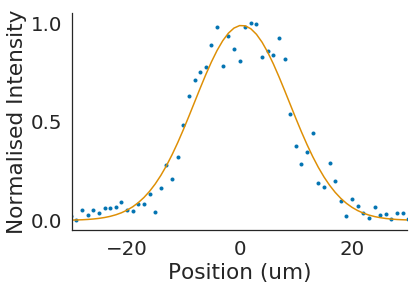

In [15]:

fig = plt.figure()
x_axis = correct_axis(x, gaus_fit)

#plot the data, to confirm gaus and spline fit
plt.plot(x_axis,y,'.',label='data')
plt.plot(x_axis,gaus_fit,label='fit')

#splines 
#plt.plot(100*[r1], np.linspace(0,max(gaus_fit), 100), c='black')
#plt.plot(100*[r2], np.linspace(0,max(gaus_fit), 100), c='black')


plt.xlabel('Position (um)')
plt.ylabel('Normalised Intensity')
plt.yticks([0,0.5,1])
plt.xlim([-1.5*FWHM,1.5*FWHM])
sns.despine()

#save the plot
save_path = r'/home/jamesrowland/Desktop/imaging_figures'
save_path = os.path.join(save_path, 'SLM_PSF.svg')
#save_path = os.path.join(save_path, 'imaging_PSF.svg')
plt.savefig(save_path)

plt.show()